# Data Science and Health Final Project: Short/Long Term Mortality Prediction
### Group: Yijia Hu, Zengtian Deng, Yuankai Qi, Marcelo Lerendegui



# Overview and Background

Mortality prediction of ICU patients is a crucial task. It is important to accurately predict the mortality of a patient because it benefits both the patient and health care rpofessionals. Also, it helps to improve the health care quality, increase efficiency for hospitals and lower the increasing healthcare cost. 

Machine learning models have been applied to many kinds of diseases such as heart failure, breast cancer, kidney disease for mortality prediction. Using the MIMIC-III dataset, we compared several machine learning models that predicts whether a patient will die in both short and long term, 30 days and 1 year respectively. We choose the data within first 24 hour after admission including patients vitals, lab results, risk scores, etc. 

30-day mortality is an important feature which hospitals are graded on across the country. It's an indication of the health care quality provided by the hospitals. Thus prediction for 30-day mortality is crucial for hospitals. It helps physicians to decide which methods would be the best for given patients and perhaps provide palliative care. 


1-year mortality is crucial for improving the quality of care over time. The patient and his/her physician are working cooperatively for health management. The risk for patients with chronic diseases is changing as time goes. Knowing the possible future scenarios is important to provide high quality, cost-effective medical care. 








# Import data from SQL database

- We ues `PostgreSQL` recommended by the Physionet to host sql server [tutorial here](https://mimic.physionet.org/tutorials/install-mimic-locally-windows/)
- We build all the concepts from `make-concepts.sql`     [link](https://github.com/MIT-LCP/mimic-code/tree/master/concepts)
- the original `all data` is from [link](https://github.com/YaronBlinder/MIMIC-III_readmission/blob/master/all_data.sql)
    we add `patient.dod` 
- More features are added, with reference to [MIT-LCP mimic repo](https://github.com/MIT-LCP/mimic-code/tree/master/concepts)
and [this paper](http://jscdss.com/index.php/files/article/view/177)
- true is defined in this notebook as well, `thirty_days` and `one_year`

### newly added features to all_data
- patients: `DOD`
- ELIXHAUSER_AHRQ_SCORE : `elixhauser_vanwalraven`, `elixhauser_sid29`, `elixhauser_sid30`
- admissions: `admission_type`, `admission_location`,    `discharge_location`, `ethnicity`, `diagnosis`
- icustay_detail: `los_hospital`
- vitalsfirstday: `meanbp_min`, `meanbp_max`, `meanbp_mean`, `spo2_min`, `spo2_max`,`spo2_mean`
- ventfirstday : `vent`
- rrtfirstday: `rrt`
- uofirstday: `urineoutput`
- LODS: `lods`
- SIRS: `sirs`


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns; sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set2')
# %matplotlib inline
plt.rcParams.update({'figure.titlesize': 'larger', 'legend.fontsize': 15.0})

In [2]:
# create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, password =sqluser )
cur = con.cursor()

In [3]:
# Commands to run .sql file in CMD 

# psql "dbname=mimic user=postgres"
# \i all_data.sql 

In [4]:
# SQL query (gets all_data view defined elsewhere)
query = \
"""
select * from all_data
"""

# Perform SQL query
cur.execute('SET search_path to ' + schema_name)
data = pd.read_sql_query(query,con)

In [5]:
print('Data shape is ',data.shape)
data.head()

Data shape is  (57996, 44)


,subject_id,hadm_id,admittime,dischtime,deathtime,dod,first_careunit,last_careunit,age,gender,...,diasbp_max,diasbp_mean,temp_min,temp_max,temp_mean,sapsii,sofa,urine_min,urine_mean,urine_max
0,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,2102-06-14,MICU,MICU,76.526788,M,...,103.0,58.64,35.222223,37.666668,36.85,79,7,5.0,143.0,600.0
1,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,NaT,SICU,SICU,65.940670,F,...,88.0,60.01,35.611110,37.444445,36.56,24,4,20.0,81.0,200.0
2,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,2149-11-14,MICU,MICU,41.790226,M,...,194.0,76.73,34.888891,37.888887,36.47,31,5,10.0,148.0,1100.0
3,12,112213,2104-08-07 10:15:00,2104-08-20 02:57:00,2104-08-20 02:57:00,2104-08-20,SICU,SICU,72.372364,M,...,111.0,72.41,35.500001,38.500002,37.24,41,3,30.0,172.0,540.0
4,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaT,NaT,CCU,CSRU,39.866116,F,...,90.0,65.22,35.944443,38.599998,37.48,13,1,30.0,98.0,260.0


# Adding more concepts using SQL and DataFrame

In [6]:
new_quey = \
"""
set search_path to mimiciii;

            (select 
                eas.hadm_id, eas.elixhauser_vanwalraven, eas.elixhauser_sid29, eas.elixhauser_sid30
            from 
                ELIXHAUSER_AHRQ_SCORE eas
                )


"""
checking = pd.read_sql_query(new_quey, con)
checking = checking.drop_duplicates(subset='hadm_id')
data = pd.merge(data, checking, on='hadm_id', how ='left')
print('Data shape is ',data.shape)
# data.head()

Data shape is  (57996, 47)


In [7]:
new_quey = \
"""
set search_path to mimiciii;

            (select distinct 
                icd.hadm_id, icd.los_hospital
            from 
                icustay_detail icd
                )


"""
checking = pd.read_sql_query(new_quey, con)
checking = checking.drop_duplicates(subset='hadm_id')
data = pd.merge(data, checking, on='hadm_id', how ='left')
print('Data shape is ',data.shape)
# data.head()

Data shape is  (57996, 48)


In [8]:
new_quey = \
"""
set search_path to mimiciii;

            select distinct
                vfd.hadm_id, vfd.meanbp_min, vfd.meanbp_max, vfd.meanbp_mean,
                vfd.spo2_min, vfd.spo2_max, vfd.spo2_mean
            from
                vitalsfirstday  vfd
                


"""
checking = pd.read_sql_query(new_quey, con)
checking = checking.drop_duplicates(subset='hadm_id')
data = pd.merge(data, checking, on='hadm_id', how ='left')
print('Data shape is ',data.shape)
# data.head()

Data shape is  (57996, 54)


In [9]:
new_quey = \
"""
set search_path to mimiciii;

select distinct 
                ventfirstday.hadm_id, ventfirstday.vent
            from
                ventfirstday
                


"""
checking = pd.read_sql_query(new_quey, con)
checking = checking.drop_duplicates(subset='hadm_id')
data = pd.merge(data, checking, on='hadm_id', how ='left')
print('Data shape is ',data.shape)
# data.head()

Data shape is  (57996, 55)


In [10]:
new_quey = \
"""
set search_path to mimiciii;

select distinct 
                rrtfirstday.hadm_id, rrtfirstday.rrt
            from 
                rrtfirstday

"""
checking = pd.read_sql_query(new_quey, con)
checking = checking.drop_duplicates(subset='hadm_id')
data = pd.merge(data, checking, on='hadm_id', how ='left')
print('Data shape is ',data.shape)
# data.head()

Data shape is  (57996, 56)


In [11]:
new_quey = \
"""
set search_path to mimiciii;

select distinct 
                uofirstday.hadm_id, uofirstday.urineoutput
            from 
                uofirstday

"""
checking = pd.read_sql_query(new_quey, con)
checking = checking.drop_duplicates(subset='hadm_id')
data = pd.merge(data, checking, on='hadm_id', how ='left')
print('Data shape is ',data.shape)
# data.head()

Data shape is  (57996, 57)


In [12]:
new_quey = \
"""
set search_path to mimiciii;

select distinct 
                OASIS.hadm_id, OASIS.icustay_age_group, OASIS.oasis
            from
                OASIS

"""
checking = pd.read_sql_query(new_quey, con)
checking = checking.drop_duplicates(subset='hadm_id')
data = pd.merge(data, checking, on='hadm_id', how ='left')
print('Data shape is ',data.shape)
# data.head()

Data shape is  (57996, 59)


In [13]:
new_quey = \
"""
set search_path to mimiciii;

select distinct 
                lods.hadm_id, lods.lods
            from 
                LODS

"""
checking = pd.read_sql_query(new_quey, con)
checking = checking.drop_duplicates(subset='hadm_id')
data = pd.merge(data, checking, on='hadm_id', how ='left')
print('Data shape is ',data.shape)
# data.head()

Data shape is  (57996, 60)


In [14]:
new_quey = \
"""
set search_path to mimiciii;

select distinct
                sirs.hadm_id, sirs.sirs
            from 
                SIRS

"""
checking = pd.read_sql_query(new_quey, con)
checking = checking.drop_duplicates(subset='hadm_id')
data = pd.merge(data, checking, on='hadm_id', how ='left')
print('Data shape is ',data.shape)
# data.head()

Data shape is  (57996, 61)


In [15]:
new_quey = \
"""
set search_path to mimiciii;

select distinct 
            ad.hadm_id, ad.admission_type, ad.admission_location, ad.discharge_location, ad.ethnicity, ad.diagnosis
            from 
                admissions ad

"""
checking = pd.read_sql_query(new_quey, con)
checking = checking.drop_duplicates(subset='hadm_id')
data = pd.merge(data, checking, on='hadm_id', how ='left')
print('Data shape is ',data.shape)
# data.head()

Data shape is  (57996, 66)


# Preliminary statistics

In [16]:
# store the data into csv
data.to_csv('data(raw).csv',index=False)

In [17]:
print('Data shape is ',data.shape)
data.head()

Data shape is  (57996, 66)


,subject_id,hadm_id,admittime,dischtime,deathtime,dod,first_careunit,last_careunit,age,gender,...,urineoutput,icustay_age_group,oasis,lods,sirs,admission_type,admission_location,discharge_location,ethnicity,diagnosis
0,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,2102-06-14,MICU,MICU,76.526788,M,...,497.0,adult,57,10,3,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,WHITE,HYPOTENSION
1,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,NaT,SICU,SICU,65.940670,F,...,1940.0,adult,11,5,1,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,WHITE,CHRONIC RENAL FAILURE/SDA
2,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,2149-11-14,MICU,MICU,41.790226,M,...,887.0,adult,35,4,3,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA
3,12,112213,2104-08-07 10:15:00,2104-08-20 02:57:00,2104-08-20 02:57:00,2104-08-20,SICU,SICU,72.372364,M,...,1425.0,adult,26,5,3,ELECTIVE,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,WHITE,PANCREATIC CANCER/SDA
4,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaT,NaT,CCU,CSRU,39.866116,F,...,1375.0,adult,34,2,4,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,WHITE,CORONARY ARTERY DISEASE


In [18]:
print ('Number of unique patient ids: {}'.format(len(data.subject_id.unique())))

Number of unique patient ids: 34005


## Describe numerical data 

In [19]:
data[['age','sapsii','sofa']].describe()

,age,sapsii,sofa
count,57996.000000,57996.000000,57996.000000
mean,75.415010,36.797400,4.556797
std,53.924155,14.494745,3.241760
min,14.911113,0.000000,0.000000
25%,54.070590,27.000000,2.000000
50%,66.827321,35.000000,4.000000
75%,78.174955,45.000000,6.000000
max,310.280859,118.000000,22.000000


In [20]:
data.loc[data.age<300].age.describe()

count    55099.000000
mean        63.580520
std         16.022694
min         14.911113
25%         53.328980
50%         65.703551
75%         76.578615
max         89.003531
Name: age, dtype: float64

In [21]:
data[['resprate_min', 'resprate_max', 'resprate_mean',]].describe()

,resprate_min,resprate_max,resprate_mean
count,57981.000000,57981.000000,57981.000000
mean,9.782119,32.962557,19.375751
std,3.727347,9.072195,3.539746
min,0.170000,8.000000,7.333333
25%,7.000000,26.000000,16.846774
50%,10.000000,31.000000,19.040404
75%,12.000000,38.000000,21.526316
max,33.000000,69.000000,43.777778


In [22]:
data[['urea_n_min','urea_n_mean','urea_n_max',]].describe()

,urea_n_min,urea_n_mean,urea_n_max
count,57963.000000,57963.000000,57963.000000
mean,16.463710,27.333612,42.224557
std,13.314368,18.915366,31.176981
min,0.000000,1.421053,2.000000
25%,9.000000,14.500000,20.000000
50%,13.000000,21.285714,31.000000
75%,19.000000,34.500000,55.000000
max,161.000000,232.040000,290.000000


In [23]:
data[['magnesium_max','albumin_min','calcium_min']].describe()

,magnesium_max,albumin_min,calcium_min
count,57548.000000,41367.000000,56248.000000
mean,2.501767,2.799359,7.673363
std,1.012201,0.757489,0.863674
min,0.400000,0.900000,0.000000
25%,2.200000,2.200000,7.200000
50%,2.400000,2.700000,7.700000
75%,2.700000,3.300000,8.200000
max,58.000000,5.700000,17.900000


In [24]:
data[['glucose_min','glucose_mean','glucose_max']].describe()

,glucose_min,glucose_mean,glucose_max
count,57638.000000,57638.000000,57638.000000
mean,86.977461,137.750363,271.053735
std,30.178478,86.866399,5961.165184
min,0.106000,21.000000,21.000000
25%,70.000000,117.142857,157.000000
50%,86.000000,130.800000,197.000000
75%,101.000000,149.946429,265.000000
max,485.000000,17994.482143,999999.000000


In [25]:
data[['hr_min','hr_mean','hr_max']].describe()

,hr_min,hr_mean,hr_max
count,57994.000000,57994.000000,57994.000000
mean,62.747368,85.759691,118.006071
std,14.767748,13.134256,25.515820
min,0.350000,34.710000,39.000000
25%,54.000000,76.770000,99.000000
50%,63.000000,85.140000,116.000000
75%,72.000000,94.430000,134.000000
max,141.000000,163.880000,285.000000


In [26]:
data[['sysbp_min','sysbp_mean','sysbp_max']].describe()

,sysbp_min,sysbp_mean,sysbp_max
count,57988.000000,57988.000000,57988.000000
mean,79.984309,120.333388,165.783576
std,21.150334,15.593030,28.935278
min,0.060000,29.170000,45.000000
25%,70.000000,109.130000,145.000000
50%,81.000000,118.670000,162.000000
75%,93.000000,130.192500,183.000000
max,181.000000,215.830000,355.000000


In [27]:
data[['diasbp_min','diasbp_mean','diasbp_max']].describe()

,diasbp_min,diasbp_mean,diasbp_max
count,57988.00000,57988.000000,57988.000000
mean,35.72244,60.253103,99.736583
std,12.31615,9.708390,27.585497
min,0.32000,14.500000,25.000000
25%,27.00000,53.657500,82.000000
50%,36.00000,59.300000,95.000000
75%,44.00000,66.060000,111.000000
max,105.00000,117.870000,298.000000


In [28]:
data[['temp_min','temp_mean','temp_max']].describe()

,temp_min,temp_mean,temp_max
count,57907.000000,57907.000000,57907.000000
mean,35.625338,36.848842,37.977907
std,0.919910,0.527247,0.882785
min,15.000000,30.000000,30.000000
25%,35.277778,36.530000,37.333333
50%,35.666667,36.830000,37.888889
75%,36.111111,37.170000,38.500002
max,40.000000,40.120000,46.500000


In [29]:
data[['urine_min','urine_mean','urine_max']].describe()

,urine_min,urine_mean,urine_max
count,57985.000000,57985.000000,5.798500e+04
mean,25.898059,126.103510,6.679872e+02
std,62.026718,537.055435,1.935803e+04
min,0.000000,0.000000,0.000000e+00
25%,0.000000,77.000000,3.000000e+02
50%,15.000000,110.000000,4.500000e+02
75%,30.000000,149.000000,6.500000e+02
max,3100.000000,119965.000000,4.555555e+06


In [30]:
data[['platelets_min','platelets_mean','platelets_max']].describe()

,platelets_min,platelets_mean,platelets_max
count,57953.000000,57953.000000,57953.000000
mean,158.938562,238.752800,353.653012
std,93.330341,117.351249,195.654320
min,4.000000,9.562500,12.000000
25%,98.000000,161.750000,224.000000
50%,148.000000,221.448276,309.000000
75%,207.000000,296.000000,434.000000
max,1328.000000,1551.387097,2813.000000


## Describe categorical data 

In [31]:
data.gender.value_counts(dropna=False)

M    32392
F    25604
Name: gender, dtype: int64

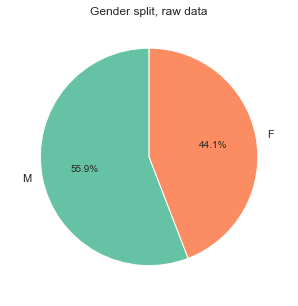

In [32]:
fig = plt.figure(figsize=(5,5))
data.gender.value_counts(dropna=False).plot.pie(startangle = 90, autopct='%1.1f%%')
plt.title('Gender split, raw data')
plt.ylabel('')
# plt.savefig('figures/raw_gender.png')
plt.show()

In [33]:
data.marital_status.value_counts(dropna=False)

MARRIED              27989
SINGLE               14024
WIDOWED               8304
DIVORCED              3821
NaN                   2826
SEPARATED              616
UNKNOWN (DEFAULT)      400
LIFE PARTNER            16
Name: marital_status, dtype: int64

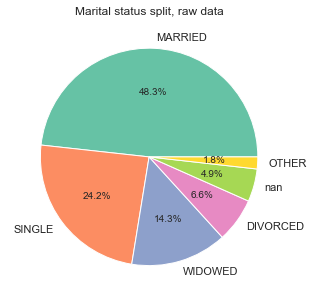

In [34]:
# reorganize for better plotting 
plotting = (data.marital_status.value_counts(dropna=False))
plotting['OTHER'] = plotting['UNKNOWN (DEFAULT)'] + plotting['LIFE PARTNER'] + plotting['SEPARATED']
plotting = plotting.drop(['UNKNOWN (DEFAULT)', 'LIFE PARTNER', 'SEPARATED'])
plotting

fig = plt.figure(figsize=(5,5))
plotting.plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('Marital status split, raw data')
plt.ylabel('')
# fig.savefig('figures/raw_marital.png')
plt.show()

In [35]:
data.insurance.value_counts(dropna=False)

Medicare      33146
Private       18074
Medicaid       4883
Government     1371
Self Pay        522
Name: insurance, dtype: int64

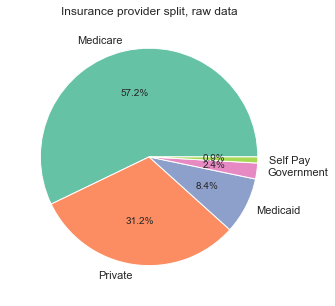

In [36]:
fig = plt.figure(figsize=(5,5))
data.insurance.value_counts(dropna=False).plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('Insurance provider split, raw data')
plt.ylabel('')
# fig.savefig('figures/raw_insurance.png')
plt.show()

In [37]:
data.first_careunit.value_counts(dropna=False)

MICU     20431
CSRU     10857
SICU     10777
CCU       8167
TSICU     7764
Name: first_careunit, dtype: int64

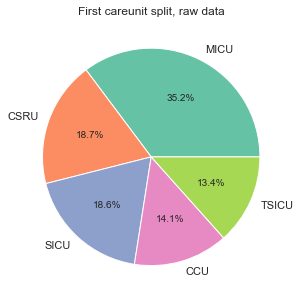

In [38]:
fig = plt.figure(figsize=(5,5))
data.first_careunit.value_counts(dropna=False).plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('First careunit split, raw data')
plt.ylabel('')
# fig.savefig('figures/raw_insurance.png')
plt.show()

In [39]:
data.last_careunit.value_counts(dropna=False)

MICU     20853
SICU     11277
CSRU     10862
CCU       7670
TSICU     7334
Name: last_careunit, dtype: int64

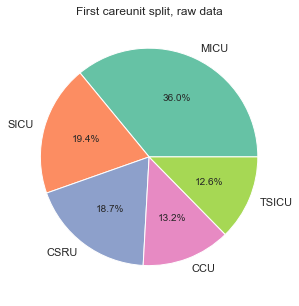

In [40]:
fig = plt.figure(figsize=(5,5))
data.last_careunit.value_counts(dropna=False).plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('First careunit split, raw data')
plt.ylabel('')
plt.show()

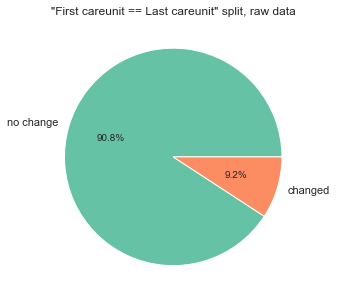

In [41]:
plotting = pd.Series(np.where(data.first_careunit == data.last_careunit, 'no change', 'changed'))
fig = plt.figure(figsize=(5,5))
plotting.value_counts(dropna=False).plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('"First careunit == Last careunit" split, raw data')
plt.ylabel('')
plt.show()

In [42]:
data.dod.describe()

count                   28655
unique                  11865
top       2191-04-07 00:00:00
freq                      107
first     2100-08-19 00:00:00
last      2211-06-10 00:00:00
Name: dod, dtype: object

## Check the missing data 

In [43]:
np.sum(data.isnull())

subject_id                    0
hadm_id                       0
admittime                     0
dischtime                     0
deathtime                 48877
dod                       29341
first_careunit                0
last_careunit                 0
age                           0
gender                        0
marital_status             2826
insurance                     0
urea_n_min                   33
urea_n_max                   33
urea_n_mean                  33
platelets_min                43
platelets_max                43
platelets_mean               43
magnesium_max               448
albumin_min               16629
calcium_min                1748
resprate_min                 15
resprate_max                 15
resprate_mean                15
glucose_min                 358
glucose_max                 358
glucose_mean                358
hr_min                        2
hr_max                        2
hr_mean                       2
                          ...  
temp_min

# Define label: die with 30 days or 1 year

In [44]:
# construct label: when the patient die
data.deathtime  = data.deathtime.combine_first(data.dod)  # merge DOD into deathtime 
data[['admittime','dod', 'deathtime']]
data['time_before_death'] = data.deathtime-data.admittime  # claculate time before death
data['time_before_death'].fillna(timedelta(days=400)) # fill NaN with 400 days, which means they did not die

data['thirty_days'] = np.where(data['time_before_death'] <= timedelta(days=30), 1, 0) # if die within 30 days, 1
data['one_year'] = np.where(data['time_before_death'] <= timedelta(days=365), 1, 0) # if die within 1 year, 1 

In [45]:
data.thirty_days.value_counts(dropna=False)  # imbalanced data set 

0    49225
1     8771
Name: thirty_days, dtype: int64

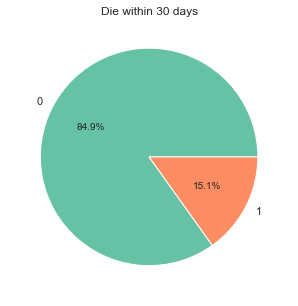

In [46]:
fig = plt.figure(figsize=(5,5))
data.thirty_days.value_counts(dropna=False).plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('Die within 30 days')
plt.ylabel('')
plt.show()

In [47]:
data.one_year.value_counts(dropna=False)  # not too imbalanced

0    38643
1    19353
Name: one_year, dtype: int64

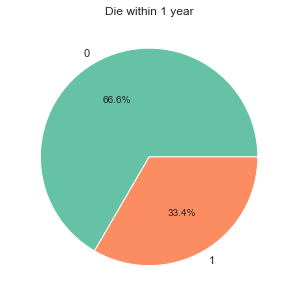

In [48]:
fig = plt.figure(figsize=(5,5))
data.one_year.value_counts(dropna=False).plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('Die within 1 year')
plt.ylabel('')
plt.show()

# Correlation heatmap for all numerical columns

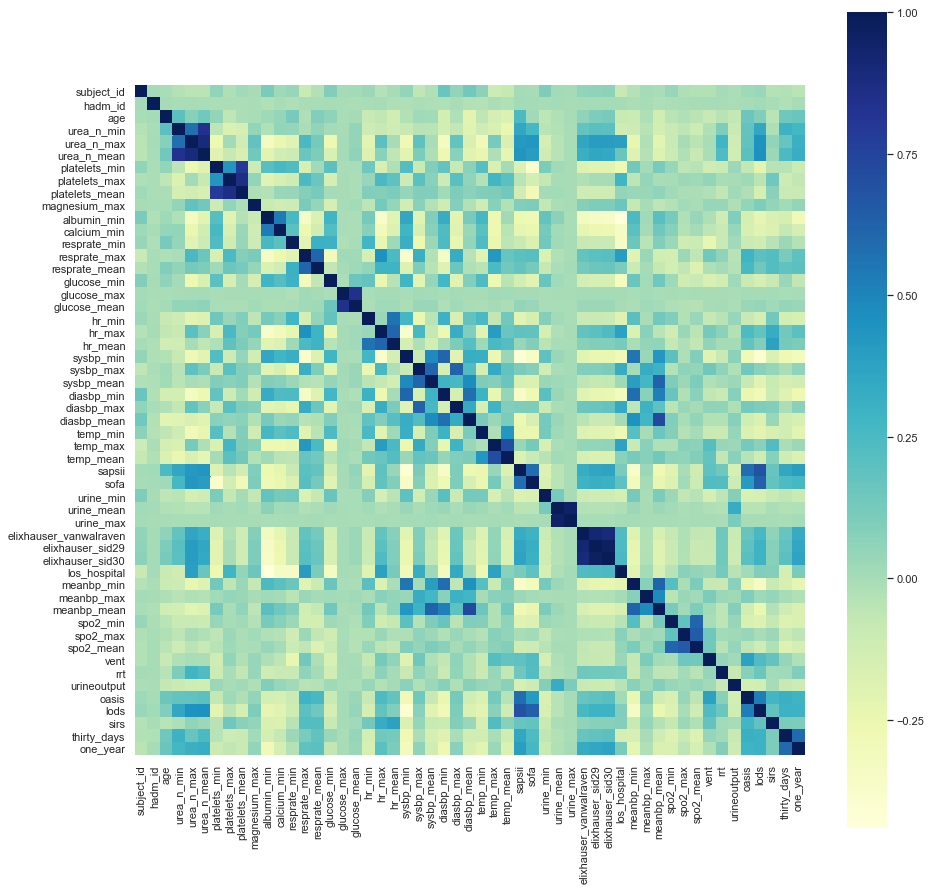

In [49]:
correlation = data.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, vmax=1, square=True, annot=False, cmap='YlGnBu')

### Save the labeled data into csv file 

In [50]:
# Save clean dataset to csv
data.to_csv('data(with_label).csv', index=False)